Steps were taken in the project:
1. Denoising the video frames using blurring kernel;
2. rayscaling and detecting edges on the frames with Canny edge detection;
3. Drawing region of interest to embed lanes on the video frame;
4. Perspective warping;
5. Segmentation of lanes using vertical histogram projection;
6. Detecting lines on the video frame using Hough Lines Polar and line optimization;
7. Displaying lines on the frame;
8. Turn prediction;
9. Whole process orchestrator;

https://towardsdatascience.com/tutorial-build-a-lane-detector-679fd8953132

https://automaticaddison.com/the-ultimate-guide-to-real-time-lane-detection-using-opencv/

https://shirolepranav.github.io/blog/computer%20vision/opencv/2020/08/30/lane-detection.html

# Libraries

In [1]:
# %pip install keyboard
# %pip install mss
# %pip install pyautogui
# %pip install pygetwindow
import pyautogui as py
import pydirectinput
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL as ImageGrab
import pyautogui as py
import pydirectinput
import keyboard
import numpy as np
import cv2 as cv
import os
import math
import time
import numpy
from mss import mss

# Image Processing / Collection

**The screenshots are for Object Detection Purpose**

In [4]:
def capture_screenshots(num_screenshots, delay=1, save_dir="screenshots"):
    # Create the directory if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    for i in range(num_screenshots):
        # Capture screenshot
        screenshot = py.screenshot(region=(50,50, 800, 600))
        # {"top": 50, "left": 50, "width": 800, "height": 600}
        # capture fullscreen
        # screenshot = py.screenshot()
        
        # Save the screenshot to the specified directory with a unique filename
        save_path = os.path.join(save_dir, f'screenshot_{i+1}.png')
        screenshot.save(save_path)
        
        print(f'Screenshot {i+1} saved at {save_path}')
        
        # Add delay between screenshots
        time.sleep(delay)
    
    print(f"{num_screenshots} screenshots captured and saved in {save_dir}!")

# Example: Take 10 screenshots with a 1-second delay between each, store them in "my_game_screenshots" directory
capture_screenshots(6, delay=1, save_dir="my_game_screenshots")

Screenshot 1 saved at my_game_screenshots\screenshot_1.png
Screenshot 2 saved at my_game_screenshots\screenshot_2.png
Screenshot 3 saved at my_game_screenshots\screenshot_3.png
Screenshot 4 saved at my_game_screenshots\screenshot_4.png
Screenshot 5 saved at my_game_screenshots\screenshot_5.png
Screenshot 6 saved at my_game_screenshots\screenshot_6.png
6 screenshots captured and saved in my_game_screenshots!


**Brightness**

**Scalling**

**Simple threshold for segmentation**

In [ ]:
img = cv.imread('D:/Thinkin in programming/Metopen/image.png', cv.IMREAD_GRAYSCALE)
_, binary_image = cv.threshold(img, 127, 255, cv.THRESH_BINARY)

cv.imshow('img',img)
cv.waitKey(0)
cv.imshow('global threshold',binary_image)

cv.waitKey(0)
cv.destroyAllWindows()

# Edge detection using Canny Edge Detection 

In [2]:
def canny_edge_detection(img):

    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY )
    kernel = 5
    blur = cv.GaussianBlur(gray, (kernel, kernel),0)
    canny = cv.Canny(blur, 50, 150)
    
    return canny

# Region of Interest

In [ ]:
def roi(img):
    height = img.shape[0]
    width = img.shape[1]
    
    # Road mask
    mask = np.zeros_like(img)
    # car_mask = np.zeros_like(img)
    
    # Define the coordinates for the trapezoid region
    # Adjust these points based on the shape of the lane and the car's position
    roi_points = np.float32([
            (274, 254),  # Top-left (screenshot-based)
            (517, 254),  # Top-right
            (748, 313),  # Bottom-right
            (13, 313)    # Bottom-left
        ])
        
    # Fill the triangular region
    cv.fillPoly(mask, roi_points, 255)
    #cv.fillPoly(mask, [car_triangle],0)
    
    # Use bitwise_and to apply the mask
    masked_image = cv.bitwise_and(img, mask)
    
    # cv.imshow("ROI Applied", masked_image)
    # cv.waitKey(0)
    # cv.destroyAllWindows()
    
    return masked_image


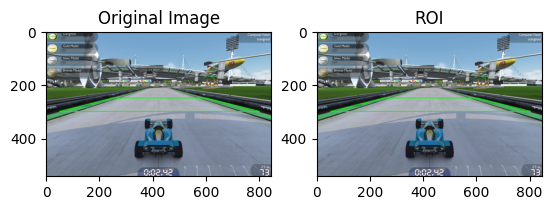

In [ ]:
def draw_road_roi(img):
    height, width = img.shape[0], img.shape[1]

    # Define a triangle that captures the road area in front of the car
    # triangle = np.array([
    #     [(int(width * 0.1), height),           # Bottom-left: 10% from the left of the frame
    #      (int(width * 0.5), int(height * 0.6)), # Top-middle: center of the frame, 60% up
    #      (int(width * 1.2), height)]           # Bottom-right: 90% from the left of the frame
    # ], np.int32)
    # HARDCODE
    roi_points = np.array([
    [((250), (250)),    # Top-left corner
     ((600), (250)),    # Top-right corner     
     ((800), (300)),    # Bottom-right corner
     ((50),  (300))]    # Bottom-left corner    
    ], np.int32)

    # Draw the triangle on the image for visualization
    cv.polylines(img, [roi_points], isClosed=True, color=(0, 255, 0), thickness=2)
    return img

# Example usage:
# img_cvt = takeSS()  # Capture screenshot and convert


# cv.imshow("Road Roi", img_with_triangle)
# cv.waitKey(0)
# cv.destroyAllWindows()
img = cv.imread('D:/Thinkin in programming/Metopen/my_game_screenshots/screenshot_5.png')
img_with_triangle = draw_road_roi(img)
    
    
    # skyview = cv.warpPerspective(img, matrix, (width, height))

    # return skyview
plt.subplot(1,2,1)
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.title('Original Image')

plt.subplot(1,2,2)
plt.imshow(cv.cvtColor(img_with_triangle, cv.COLOR_BGR2RGB))
plt.title("ROI")

plt.show()

Coordinate Explanation:
* (int(width * 0.1), height) defines the bottom-left point of the triangle (10% of the frame width from the left, and at the bottom).
* (int(width * 0.5), int(height * 0.5)) is the top-middle point of the triangle (center of the width, and 50% down from the top).
* (int(width * 0.9), height) is the bottom-right point of the triangle (90% of the frame width from the left, and at the bottom).
How to Adjust the Triangle:
Visually Inspect the Lane:

Run the program and see where the triangle is placed. 
1. Adjust the width * 0.1 and width * 0.9 values to move the triangle left or right.
2. Adjust height * 0.5 to raise or lower the top point of the triangle.

# Dynamic ROI (not yet implemented: check the Dynamic RoI Notebook)

# Define the HLD (Hough Line Detection)

In [4]:
def houghlines(img):
    hough_lines = cv.HoughLinesP(
        img,
        rho=6,  # Resolution of the accumulator in pixels
        theta=np.pi / 100,  # Angle resolution in radians
        threshold=150,  # Minimum number of intersecting points
        minLineLength=30,  # Minimum length of a line
        maxLineGap=10  # Maximum allowed gap between line segments
    )
    return hough_lines

# Histogram Intensity 🥹🥹🥹
https://github.com/Infinem/Invenimus-Project/blob/master/lane_detection_with_memory/lane_detection_algorithm.py

In [5]:
def histogram (img):
    histogram = np.sum(img, axis = 0)

    # Find mid point on histogram
    midpoint = np.int32(histogram.shape[0]/2)

    # Compute the left max
    left_X = np.argmax(histogram[:midpoint])
    right_X = np.argmax(histogram[midpoint:]) + midpoint

    return left_X, right_X

img = cv.imread('D:/Thinkin in programming/Metopen/my_game_screenshots/screenshot_5.png')
left_X, right_X = histogram(img)
print(f"Left X: {left_X}, Right X: {right_X}")

Left X: 957, Right X: 849


with the following arguments:
* dst: Output of the edge detector. It should be a grayscale image (although in fact it is a binary one)
* lines: A vector that will store the parameters (r,θ) of the detected lines
* rho : The resolution of the parameter r in pixels. We use 1 pixel.
* theta: The resolution of the parameter θ in radians. We use 1 degree (CV_PI/180)
* threshold: The minimum number of intersections to "*detect*" a line
* srn and stn: Default parameters to zero. Check OpenCV reference for more info.

# Perspective warping

(https://medium.com/nerd-for-tech/lane-detection-with-opencv-part-1-ad9ea5758c07)

If we were flying over the road, and watching it from a bird’s eye view, the lanes would be parallel, but in the picture, they are not, because of the perspective.
The perspective depends on the focal length of the lens (lenses with a shorter focal length show a stronger perspective) and the position of the camera. Once the camera is mounted on a car, the perspective is fixed, so we can take it into consideration and correct the image.
OpenCV has a method to compute the perspective transformation:
**getPerspectiveTransform().**

# Perspective Transform 😫😫

https://www.youtube.com/watch?v=f41AAKV2CFM&list=PLbv11v7kH7vU85BfOS65HA8DjKgxu5hi9&index=5

Source points (trapezoid): You have four points on the game screen that define the trapezoidal region you want to transform (e.g., the area in front of the car).

Destination points (rectangle): These points should map the trapezoid into a rectangle (the skyview). The top corners of the trapezoid should become the top corners of the rectangle, and the bottom corners of the trapezoid should become the bottom corners of the rectangle.

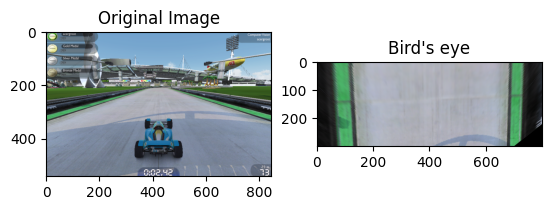

In [ ]:
def warp(): 
   
    # The offset ensures that the bird's-eye view isn't stretched too much.
    offset = 70

    # Perspective points (source points) from the original image.
    # These are the four points you want to transform from the source image.
    source_points = np.array([
        [274, 254],   # Top-left corner
        [517, 254],   # Top-right corner
        [748, 313],   # Bottom-right corner
        [13, 313]  
    ], np.float32)  # Use float32 for getPerspectiveTransform

    # The destination points for the perspective transform, where you want
    # the source points to be mapped to in the resulting image.
    # The offset is used to shrink the window a bit.
    destination_points = np.array([
        [100, 0],           # Top-left (smaller padding)
        [700, 0],           # Top-right
        [700, 600],         # Bottom-right (match height)
        [100, 600]  
    ], np.float32)
    # Changed the data type to np.float32 for both source_points and destination_points,
    # which is required by cv.getPerspectiveTransform.

    # Create the perspective transformation matrix using the source points 
    # and the destination points.
    matrix = cv.getPerspectiveTransform(source_points, destination_points)
    matrix_inv = cv.getPerspectiveTransform(destination_points, source_points)
    return matrix, matrix_inv

    # Apply the perspective warp transformation to the image, generating a 
    # "skyview" of the image.
def front_to_top(img):
    M,_ =  warp()
    size = (800, 300)

    return cv.warpPerspective(img, M, size, flags=cv.INTER_LINEAR)
def top_to_front(img):
    _,m_inv = warp()
    size = (800, 300)

    return cv.warpPerspective(img, m_inv, size, flags=cv.INTER_LINEAR)


img = cv.imread('D:/Thinkin in programming/Metopen/my_game_screenshots/screenshot_5.png')
output = front_to_top(img)
# cv.imshow('img',img)
# cv.imshow('image', output)
# cv.waitKey(0)
    
    
    # skyview = cv.warpPerspective(img, matrix, (width, height))

    # return skyview
plt.subplot(1,2,1)
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.title('Original Image')

plt.subplot(1,2,2)
plt.imshow(cv.cvtColor(output, cv.COLOR_BGR2RGB))
plt.title("Bird's eye")

plt.show()


# Line Optimization

In [12]:
def make_points(img, lineSI):
    slope, intercept = lineSI
    # height = roi_bottom  # Use the bottom coordinate of the ROI
    y1 = int(img.shape[0])  # Bottom of the ROI
    y2 = int(y1 * 0.5)  # Extend the line slightly beyond the bottom of the ROI

    # Calculate x coordinates based on slope and intercept
    x1 = int((y1 - intercept) / slope)
    x2 = int((y2 - intercept) / slope)

    return [[x1, y1, x2, y2]]  # Return the points in the format required by cv.line


# Before running this code below, you need to make sure that the line of the lane and the car
# is already correct. Specify the correct region of interest first
def average_slope_intercepts(img, lines):
    
    # lane_lines = [] # Both lines

    left_fit = []
    right_fit = []
    
    if lines is None:
        return None
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            # Check for a valid line length (avoid horizontal/vertical short lines)
            fit = np.polyfit((x1, x2), (y1, y2), 1)
            slope = fit[0]
            intercept = fit[1]
            # Filter based on slope: negative for left, positive for right
            if slope < 0:  # Left lane
                left_fit.append((slope, intercept))
            elif slope > 0:  # Right lane
                right_fit.append((slope, intercept))
            # if abs(x2 - x1) > 0 and abs(y2 - y1) > 0:  
                
    left_fit_average  = np.average(left_fit, axis=0)
    right_fit_average = np.average(right_fit, axis=0)
    left_line  = make_points(img, left_fit_average)
    right_line = make_points(img, right_fit_average)
    average_lines = [left_line, right_line]


    return average_lines


def display_lines_average(img, lines):
    # line_image = [0]
    line_image = np.zeros_like(img)
    if lines is not None:
        for line in lines:
            for x1, y1, x2, y2 in line:
                cv.line(line_image, (x1,y1), (x2,y2), (0,0,255),10)
    # return img
    return line_image

The main logic of this part is to make turn prediction using the central point between two lines.

https://medium.com/@SunEdition/lane-detection-and-turn-prediction-algorithm-for-autonomous-vehicles-6423f77dc841

https://github.com/Infinem/Invenimus-Project/blob/master/lane_detection_with_memory/lane_detection_algorithm.py

https://www.youtube.com/watch?v=Rmy2HRtYTYw&list=PLbv11v7kH7vU85BfOS65HA8DjKgxu5hi9&index=3

https://medium.com/analytics-vidhya/camera-calibration-with-opencv-f324679c6eb7

# Sliding Window

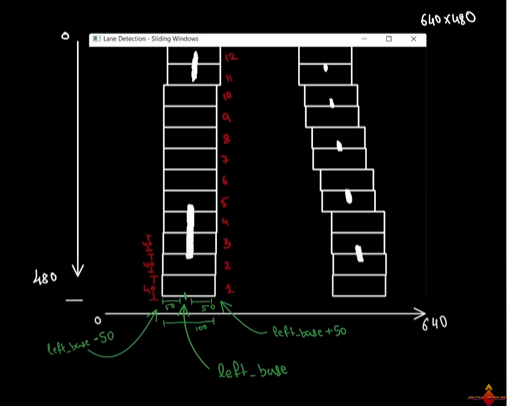

https://github.com/rogersacchelli/Lanes-Detection-with-OpenCV/blob/master/main.py

**Sliding Window Technique**
After applying the perspective transformation (bird's-eye view), the lane lines should be relatively straight. The sliding window technique can then be used to follow these lane lines and detect curves.

Here’s a step-by-step approach:

1. Apply Perspective Transformation:

    You've already done this, which is great! This will help "straighten out" the lanes and make detecting curves easier by turning the road into a top-down view.

2. Detect Lane Lines Using Sliding Windows:

    The sliding window technique can be used to detect the lane markings (left and right lane lines). You start by identifying where the lane markings are in the lower portion of the image and then slide upwards, detecting the lane as you go.

    Here’s how sliding window works:
    1. Histogram of the lower half of the image:

        * This will help you identify where the lane lines are in the lower part of the image.
        * You can sum up pixel intensities vertically to get the position of the lane lines on the   x-axis.

    2. Create Sliding Windows:

        * Start by identifying the base positions of the lanes using the histogram.
        * Create windows centered at these positions and move upwards in the image.
        * If the lane position shifts left or right significantly as you move up, you detect a turn.
    3. Check the curvature:

        * As the sliding windows move upwards, if the lane line moves to the left or right significantly, it indicates a curve.
        * You can calculate the curvature based on how much the lane positions change from the bottom to the top of the image.

3.  Measure Lane Curvature:

    You can estimate whether the car is going straight or turning by calculating the lane curvature. If the curvature is minimal, the car is on a straight path. If it's large, the car is in a turn.

    Radius of Curvature: You can fit a polynomial to the lane points detected by the sliding window technique, and use that to calculate the radius of curvature.
    * A large radius means a wide turn or straight road.
    * A small radius means a sharper turn.

4. Turn Detection Logic:
    * Left Turn: If the detected lane line shifts significantly left as you move upwards in the image.
    * Right Turn: If the lane line shifts significantly right.
    * Straight: If the lane lines remain roughly parallel and don't shift.

In [ ]:
def sliding_window(img_warped):
    histogram = np.sum(img_warped[int(img_warped.shape[0]//2):,:], axis=0)
    # find the peak of the left and right halves of the  histogram
    # this will be the starting points for the left and right lane lines
    output_img = np.zeros_like(img_warped)

    midpoint = np.int32(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Number of sliding windows
    nwindows = 10

    # Set height of windows
    window_height = np.int32(img_warped.shape[0]//nwindows)

    # Identify the x and y positions of all nonzero pixels in the image.
    nonzero = img_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current position to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # set the width of the window
    margin = 100

    # set the minimum number of pixels found to recenter window
    minpix = 50

    # create empty lits to reveive ledt and right lane pixels indices
    left_lane_inds = []
    right_lane_inds = []

    # step through the windows ine by one
    for window in range (nwindows):
        # Identify window boundaries in x and y
        win_y_low =  img_warped.shape[0] - (window+1)*window_height
        win_y_high =  img_warped.shape[0] - window*window_height    

        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin

        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Identify the nonzero pixels in x and y  within the current window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                          (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                           (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # append these indices to the list
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # if you dound >  minpix pixels, recenter next window on their mean position
        if len(good_left_inds) >  minpix:
            leftx_current = np.int32(np.mean(nonzerox[good_left_inds]))

        if len(good_right_inds) > minpix:
            rightx_current = np.int32(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds =  np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # fit a second order polynominal to each
    # left_fit = np.polyfit(lefty, leftx, 2)
    # right_fit = np.polyfit(righty, rightx, 2)

    return leftx,  lefty, rightx, righty, output_img


def fit_polynominal(binary_warped):
    leftx, lefty, rightx, righty, out_img = sliding_window(binary_warped)

    # fit a second order polynominal to each
    if len(leftx) > 0 and len(lefty) > 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    else:
        left_fit = [0, 0, 0]  # default values or handle error

    if len(rightx) > 0 and len(righty) > 0:
        right_fit = np.polyfit(righty, rightx, 2)
    else:
        right_fit = [0, 0, 0]  # default values or handle error

    return left_fit, right_fit,  out_img


def draw_lines(binary_warped, left_fit, right_fit, original_image):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # generate y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0] -1, binary_warped.shape[0])

    # calculate the x values basaed on the polynominal coefficients
    left_fitx = left_fit[0] * ploty**2  + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty**2 + right_fit[1]  * ploty + right_fit[2]

    # recast the  x and y points into usable format for cv2.fillPoly()
    left_line_points = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    right_line_points = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    points = np.hstack((left_line_points, right_line_points))

    # fill the lane area with green
    cv.fillPoly(color_warp , np.int_([points]), (0,255,0))

    # warp the blank back to the original image space using inverse perspective matrix (M_inv)
    # newwarp = cv.warpPerspective(color_warp, M_inv, (original_image.shape[1], original_image.shape[0]))
    M, M_inv = warp()
    newwarp = cv.warpPerspective(color_warp, M_inv, (original_image.shape[1], original_image.shape[0]))

    # combine the result with the original image
    result = cv.addWeighted(original_image, 1, newwarp, 0.3, 0)

    return result

    # calculate  the radius of curvature of the lane and draw it on the image

    # off center calculation

    # print text on screen


def capture_game_screen():
    # intialize the screen capture and match it with the game window
    # 5,30, 847, 542
    sct = mss()
    # monitor = {"top": 5, "left": 30, "width": 847, "height": 542}
    monitor = {"top": 30, "left": 5, "width": 800, "height": 600}

    # capture the screen
    screenshot = sct.grab(monitor)
    # conver to numpy array
    frame = numpy.array(screenshot)
    # convert from RGBA to BGR
    frame = cv.cvtColor(frame, cv.COLOR_RGBA2BGR)
    return frame


def process_frame(image):
    # Process the image
    canny_image = canny_edge_detection(image)
    masked_img = roi(canny_image)
    img_warp = front_to_top(masked_img)

    # fit polynomials
    left_fit, right_fit, out_img = fit_polynominal(img_warp)

    # Draw the detected lane lines
    result = draw_lines(img_warp, left_fit, right_fit, image)

    return canny_image, img_warp, result


def display_pipeline():
    # Initialize the webcam
    # cap = cv.VideoCapture(0) # 0 for webcam, or pass the video file path

    # create named windows
    # cv.namedWindow('Original', cv.WINDOW_NORMAL)
    cv.namedWindow('Canny Edge Detection', cv.WINDOW_NORMAL)
    cv.namedWindow('Bird\'s Eye View', cv.WINDOW_NORMAL)
    cv.namedWindow('Detected Lane Lines', cv.WINDOW_NORMAL)


    while True:
        # Capture game screen
        frame = capture_game_screen()

        # Process the frame
        canny_img, bird_view, lane_detection = process_frame(frame)

        # convert binary images to 3 channels for display
        if len(bird_view.shape) == 2:
            bird_view_display = cv.cvtColor(bird_view, cv.COLOR_GRAY2BGR)
        
        if len(canny_img.shape) == 2:
            canny_display = cv.cvtColor(canny_img, cv.COLOR_GRAY2BGR)
        

        # resize windows for better viewing
        window_width = 640
        window_height = 480

        canny_resized = cv.resize(canny_img, (window_width, window_height))
        bird_view_resized = cv.resize(bird_view, (window_width, window_height))
        lane_detection_resized = cv.resize(lane_detection, (window_width, window_height))
        
        # Show all windows
        cv.imshow('Canny Edge Detection', canny_resized)
        cv.imshow('Bird\'s Eye View', bird_view_resized)
        cv.imshow('Lane Detection', lane_detection_resized)
        
        # Break loop if 'q' is pressed
        if cv.waitKey(1) & 0xFF == ord('q'):
            break

    # clean up
    cv.destroyAllWindows()


# Run the pipeline
if __name__ == "__main__":
    display_pipeline()

# Controll the car with Direct Input

In [ ]:
class LaneFollowingControl:
    def __init__(self):
        self.sct  = mss()
        self.monitor = {"top": 5, "left": 30, "width": 847, "height": 542}

        # controll parameters
        self.center_threshold = 100 # pixel from the center before steering
        self.turn_duration = 0.1  # base turning duration
        self.last_turn_time = 0
        self.turn_cooldown = 0.2  # minimum time between turns

    def capture_and_process(self):
        screenshot = self.sct.grab(self.monitor)
        frame = numpy.array(screenshot)        
        frame = cv.cvtColor(frame, cv.COLOR_RGBA2BGR)


        # Process the frame
        canny_image = canny_edge_detection(frame)
        masked_image = roi(canny_image)
        img_warp = front_to_top(masked_image)
        left_fit, right_fit, out_img = fit_polynominal(img_warp)

        return frame, left_fit, right_fit, canny_image, img_warp, out_img
    
    def calculate_steering(self, left_fit, right_fit):
        #  Calculate the center of the lane at the bottom of the image
        y_eval = 720
        left_x = left_fit[0]*y_eval + left_fit[1]*y_eval + left_fit[2]
        right_x = right_fit[0]*y_eval + right_fit[1]*y_eval + right_fit[2]

        # calculate center of the lane
        lane_center = (left_x + right_x) / 2

        # Assume center of the car is middle of the image
        car_center = self.monitor["width"] / 2

        # calculate the offset
        offset = lane_center - car_center

        # calculate curvature
        curvature = (left_fit[0] + right_fit[0]) / 2

        return offset, curvature
    
    def control_car(self, offset, curvature):
        current_time = time.time()
        
        # Only execute turn if cooldown has elapsed
        if current_time - self.last_turn_time < self.turn_cooldown:
            return
        
        # Basic steering logic
        if abs(offset) > self.center_threshold:
            # Adjust turn duration based on offset magnitude
            turn_time = min(abs(offset) / 1000, 0.3)  # Max 0.3 seconds
            
            if offset > 0:  # Need to turn right
                pydirectinput.keyDown('d')
                print('Turn Right')
                time.sleep(turn_time)
                pydirectinput.keyUp('d')
            else:  # Need to turn left
                pydirectinput.keyDown('a')
                print('Turn Left')
                time.sleep(turn_time)
                pydirectinput.keyUp('a')
                
            self.last_turn_time = current_time

        # Always accelerate (you might want to adjust this based on curvature)
        pydirectinput.keyDown('w')

def main():
    # Initialize controller
    controller = LaneFollowingControl()
    
    # Create display windows
    cv.namedWindow('Lane Detection', cv.WINDOW_NORMAL)
    
    # Click to focus game window (adjust coordinates as needed)
    py.click(409, 275)
    time.sleep(0.5)
    
    try:
        while True:
            # Capture and process frame
            frame, left_fit, right_fit, canny_img, img_warp, out_img = controller.capture_and_process()
            
            # Calculate steering
            offset, curvature = controller.calculate_steering(left_fit, right_fit)
            
            # Control the car
            controller.control_car(offset, curvature)
            
            # Display the output
            cv.imshow('Lane Detection', out_img)
            
            # Exit if d'q' is pressed
            if cv.waitKey(1) & 0xFF == ord('q'):
                break
                
    finally:
        # Clean up
        cv.destroyAllWindows()
        pydirectinput.keyUp('w')  # Make sure we release accelerator
        pydirectinput.keyUp('a')
        pydirectinput.keyUp('d')

if __name__ == "__main__":
    main()

Turn Left
Turn Left
